In [110]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import random
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sn

## Iperparametri

In [111]:
#general
logLabel = "log44"
print_period = 50
use_dummies_input = True

#regularizzation
use_batchnorm = False
use_dropout = True
input_dropout_rate = 0.3
dropout_rate = 0.5

#layer size
use_direct_inputs = True
use_layer_regression_full = True
use_layer_regression_couple = True
n_input_regressions = [30, 10]
n_hiddens = [100]
activation_function = tf.nn.relu

#training
learning_rate = 0.001
scale_input_data = False
scale_output_data = True
batch_size = 50
test_batch_size = 100
epochs = 5000
patience = 100
min_delta = 0.001

## Ottiene i dati

In [112]:
df = pd.read_csv('patterns.csv')
#print(df.head(5))

#ottiene input e output
if use_dummies_input:
    X1 = pd.get_dummies(df.iloc[:, 0]).values.astype(np.float32)
    X2 = pd.get_dummies(df.iloc[:, 24]).values.astype(np.float32)
    for i in range(1,24):
        X1_dummy = pd.get_dummies(df.iloc[:, i]).values.astype(np.float32)
        X2_dummy = pd.get_dummies(df.iloc[:, i+24]).values.astype(np.float32)
        X1 = np.concatenate((X1, X1_dummy), axis=1)
        X2 = np.concatenate((X2, X2_dummy), axis=1)
else:
    X1 = df.iloc[:, :24].values.astype(np.float32)
    X2 = df.iloc[:, 24:48].values.astype(np.float32)
y = df.iloc[:, -1].values.astype(np.float32)

#separa dati di train da dati di test
test_size=0.33
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=test_size, random_state=42)


## Crea il modello

In [113]:
tf.reset_default_graph()

#crea i placeholder di input
n_input = X1.shape[1]
x_input1 = tf.placeholder(dtype=tf.float32, shape=[None, n_input], name="X1")
x_input2 = tf.placeholder(dtype=tf.float32, shape=[None, n_input], name="X2")
is_training = tf.placeholder(tf.bool, name="isTraining")
y_target = tf.placeholder(dtype=tf.float32, shape=[None,n_output], name='Y')
input_regressions = []

#crea un unico livello di input, per avere solo un hidden layer denso (da commentare le successive 2 sezioni)
if use_direct_inputs:
    input_regressions.append(x_input1)
    input_regressions.append(x_input2)

In [114]:
if use_layer_regression_full:
    #2 regressioni full
    with tf.variable_scope("regression_full1") as scope:
        layer = tf.layers.dense(x_input1, n_input_regressions[0], activation=activation_function)
        #if use_dropout:
            #layer = tf.layers.dropout(layer, rate=input_dropout_rate, training=is_training)
        
        #crea i livelli hidden di full1
        for i in range(1, len(n_input_regressions)):
            with tf.variable_scope("regression_hidden_full1_"+str(i)) as scope:
                layer = tf.layers.dense(layer, n_input_regressions[i], activation=activation_function)
                #if use_dropout:
                    #layer = tf.layers.dropout(layer, rate=dropout_rate, training=is_training)

        #aggiuge il layer nell'elenco delle input regression
        input_regressions.append(layer)
    
    with tf.variable_scope("regression_full2") as scope:
        layer = tf.layers.dense(x_input2, n_input_regressions[0], activation=activation_function)
        #if use_dropout:
                #layer = tf.layers.dropout(layer, rate=input_dropout_rate, training=is_training)
        
        #crea i livelli hidden di full2
        for i in range(1, len(n_input_regressions)):
            with tf.variable_scope("regression_hidden_full2_"+str(i)) as scope:
                layer = tf.layers.dense(layer, n_input_regressions[i], activation=activation_function)
                #if use_dropout:
                    #layer = tf.layers.dropout(layer, rate=dropout_rate, training=is_training)

        #aggiuge il layer nell'elenco delle input regression
        input_regressions.append(layer)

In [115]:
if use_layer_regression_couple:
    #per ogni coppia di input crea una regressione
    with tf.variable_scope("regression_couple") as scope:    
        for i in range(n_input):
            if use_dummies_input:
                layer_input = tf.concat([x_input1[:, i:i+5+1], x_input2[:, i:i+5+1]], axis=1)
            else:    
                layer_input = tf.concat([x_input1[:, i:i+1], x_input2[:, i:i+1]], axis=1)
            layer = tf.layers.dense(layer_input, n_input_regressions[0], activation=activation_function)
            #if use_dropout:
                #layer = tf.layers.dropout(layer, rate=input_dropout_rate, training=is_training)
            
            for j in range(1, len(n_input_regressions)):
                with tf.variable_scope("regression_hidden_"+str(i)+str(j)) as scope:
                    layer = tf.layers.dense(layer, n_input_regressions[j], activation=activation_function)
                    #if use_dropout:
                        #layer = tf.layers.dropout(layer, rate=dropout_rate, training=is_training)

            #aggiuge il layer nell'elenco delle input regression
            input_regressions.append(layer)


In [116]:
#concatena tutte le regressioni di ingresso (o solo gli input)
hidden_layer = tf.concat(input_regressions, axis=1)

#crea gli altri livelli hidden
for i in range(0, len(n_hiddens)):
    with tf.variable_scope("hidden_"+str(i + 1)) as scope:
        if use_batchnorm:
            hidden_layer = tf.layers.batch_normalization(hidden_layer, training=is_training)
        hidden_layer = tf.layers.dense(hidden_layer, n_hiddens[i], activation=activation_function)
        if use_dropout:
            hidden_layer = tf.layers.dropout(hidden_layer, rate=dropout_rate, training=is_training)
    
#crea il livello output
n_output = 1
with tf.variable_scope("output") as scope:
    if use_batchnorm:
        hidden_layer = tf.layers.batch_normalization(hidden_layer, training=is_training)
    output_layer = tf.layers.dense(hidden_layer, n_output)

In [117]:
#crea la funzione di costo e l'optimizer
loss = tf.losses.mean_squared_error(y_target, output_layer)

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

train_loss_summary = tf.summary.scalar('loss', loss)
test_loss_summary = tf.summary.scalar('val_loss', loss)

## Effettua il training

In [118]:
#init
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
writer = tf.summary.FileWriter(logdir='logs/'+logLabel , graph=tf.get_default_graph())
saver = tf.train.Saver()

#effettua lo scaler dei dati di ingresso
if scale_input_data:
    X_alldata = np.concatenate((X1, X2), axis=0)
    scalerX = preprocessing.MinMaxScaler().fit(X_alldata)
    X1_train_scaled = scalerX.transform(X1_train)
    X2_train_scaled = scalerX.transform(X2_train)
    X1_test_scaled = scalerX.transform(X1_test)
    X2_test_scaled = scalerX.transform(X2_test)
else:
    X1_train_scaled = X1_train
    X2_train_scaled = X2_train
    X1_test_scaled = X1_test
    X2_test_scaled = X2_test

#effettua lo scaler dei dati di uscita
if scale_output_data:
    y_train_scaled = y_train/200
    y_test_scaled = y_test/200
else:
    y_train_scaled = y_train
    y_test_scaled = y_test

In [119]:
#effettua il training
train_history_loss = list()
test_history_loss  = list()
patience_cnt = 0
res_prec_loss = float('inf')
for epoch in range(epochs):
    
    #effettua il train di un batch di dati
    rand_index = np.random.choice(len(y_train), size=batch_size)
    rand_x1 = X1_train_scaled[rand_index]
    rand_x2 = X2_train_scaled[rand_index]
    rand_y = np.transpose([y_train_scaled[rand_index]])
    res_optimizer, res_loss, res_train_lost_summary = sess.run(
        [optimizer, loss, train_loss_summary], 
        feed_dict={
          x_input1: rand_x1,
          x_input2: rand_x2,
          y_target: rand_y,
          is_training: True
        })
    
    #preiodicamente stampa la loss del train e ricalcola i dati di test per ottenere la loss di validazione
    save_loss = epoch % int(print_period * epochs / 1000) == 0
    if save_loss:
        #conserva la loss di train
        train_history_loss.append(res_loss)
        writer.add_summary(res_train_lost_summary, epoch)

        #effettua la validazione
        rand_index = np.random.choice(len(y_test), size=test_batch_size)
        rand_x1 = X1_test_scaled[rand_index]
        rand_x2 = X2_test_scaled[rand_index]
        rand_y = np.transpose([y_test_scaled[rand_index]])
        res_loss, res_test_loss_summary = sess.run(
            [loss, test_loss_summary], 
            feed_dict={
              x_input1: rand_x1,
              x_input2: rand_x2,
              y_target: rand_y,
              is_training: False
            })
        
        #conserva la loss di validazione
        test_history_loss.append(res_loss)
        writer.add_summary(res_test_loss_summary, epoch)

    #gestisce l'early stopping
    if epoch > 0 and res_prec_loss-res_loss > min_delta:
        patience_cnt = 0
    else:
        patience_cnt += 1
    res_prec_loss = res_loss
    if patience_cnt > patience:
        print("early stopping... epoch: ", epoch)
        break
           
#salva il modello e gli scaler
saver.save(sess, "./saved/model.ckpt")
if scale_input_data:
    joblib.dump(scalerX, './saved/scalerX.pkl') 

## Stampa le perdite

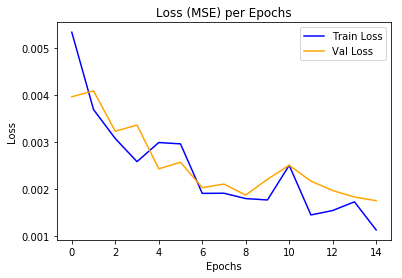

In [120]:
#stampo la perdita
start_plot_index = 5
plt.plot(train_history_loss[start_plot_index:], 'blue', label='Train Loss')
plt.plot(test_history_loss[start_plot_index:], 'orange', label='Val Loss')
plt.title('Loss (MSE) per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## Effettua le predictions

In [121]:
#ottiene l'output dai dati di test
feed_dict = {
  x_input1: X1_test_scaled,
  x_input2: X2_test_scaled,
  is_training: False
}
res_output_layer = sess.run([output_layer], feed_dict=feed_dict)

#trasforma gli output in predictions
predictions = []
if scale_output_data:
    res_output_layer_unscaled = res_output_layer[0]*200
else:
    res_output_layer_unscaled = res_output_layer[0]
for i in range(len(res_output_layer_unscaled)):
    predictions.append(res_output_layer_unscaled[i][0])

#trasforma i dati Y di test in labels    
labels = []
for i in range(len(y_test)):
    labels.append(y_test[i])
    
#stampa un esempio di predizioni
print("Prediction example: ", predictions[:10])

Prediction example:  [86.96857, 86.04302, 88.1785, 50.496315, 84.52081, 63.652695, 106.87029, 36.572937, 61.923725, 49.12987]


In [122]:
##prova una support vector machine
#from sklearn.svm import SVR
#svr = SVR(kernel='poly', C=1e3, degree=2)
#X_train = np.concatenate((X1_train_scaled, X2_train_scaled), axis=1)
#X_test = np.concatenate((X1_test_scaled, X2_test_scaled), axis=1)
#svr.fit(X_train, Y_train)
#predictions = svr.predict(X_test)

## Valuta il modello in base alla regressione

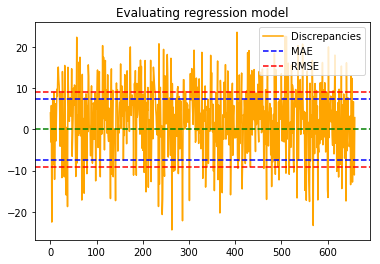

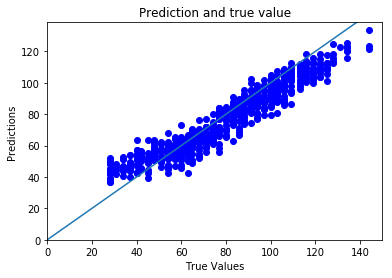

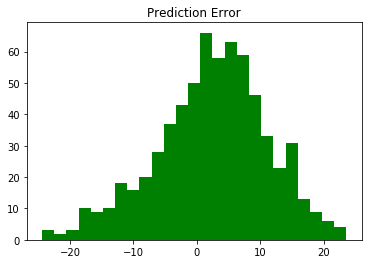

MAE:  7.339971  (→ 0)
RMSE:  9.06028688966024  (→ 0)
R^2:  0.8817011061538185  (→ 1)


In [123]:
#ottiene l' R^2 score (ottimo valore se tendente a 1)
r_square = r2_score(labels, predictions) 

#ottiene il Mean Absolute Error (MAE) (ottimo valore se tendente a 0)
mae = mean_absolute_error(labels, predictions)

#ottiene il Root Mean Squared Error (RMSE) (ottimo valore se tendente a 0)
rmse = mean_squared_error(labels, predictions)**0.5

#stampa le varie discrepanze (differenza tra il valore atteso ed il valore predetto)
discrepancies = []
for i in range(len(labels)):
    discrepancies.append(labels[i]-predictions[i])
plt.title('Evaluating regression model')
plt.plot(discrepancies, label='Discrepancies', color='orange')
plt.axhline(y=mae, color='b', linestyle='--', label='MAE')
plt.axhline(y=-mae, color='b', linestyle='--')
plt.axhline(y=rmse, color='r', linestyle='--', label='RMSE')
plt.axhline(y=-rmse, color='r', linestyle='--')
plt.axhline(y=-0, color='g', linestyle='--')
plt.legend(loc='upper right')
plt.show()

#predictions e true value
plt.scatter(labels, predictions, color='blue')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction and true value')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-500, 500], [-500, 500])
plt.show()

#distribuzione degli errori
plt.hist(discrepancies, bins=25, color='green')
plt.title("Prediction Error")
plt.show()

#stampa i risultati
print("MAE: ", mae, " (→ 0)")
print("RMSE: ", rmse, " (→ 0)")
print("R^2: ", r_square, " (→ 1)")

## Valuta il modello in base alla classificazione

In [124]:
#trasforma le predizioni in classi
def transformToClass(yr):
    yc = []
    for i in range(len(yr)):
        yi = np.zeros(7)
        if (yr[i]<70):                  yi[0] = 1 #A
        if (yr[i]>=70  and yr[i]<=83) : yi[1] = 1 #B
        if (yr[i]>=84  and yr[i]<=98) : yi[2] = 1 #C
        if (yr[i]>=99  and yr[i]<=113): yi[3] = 1 #D
        if (yr[i]>=114 and yr[i]<=128): yi[4] = 1 #E
        if (yr[i]>=129 and yr[i]<=143): yi[5] = 1 #F
        if (yr[i]>143):                 yi[6] = 1 #G
        yc.append(yi)
    yr = np.array(yc)
    return yr


c_labels = transformToClass(labels)
c_predictions = transformToClass(predictions)

accuracy_score: 0.6742
precision_score: 0.6403
recall_score: 0.6742
f1_score: 0.6465


C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


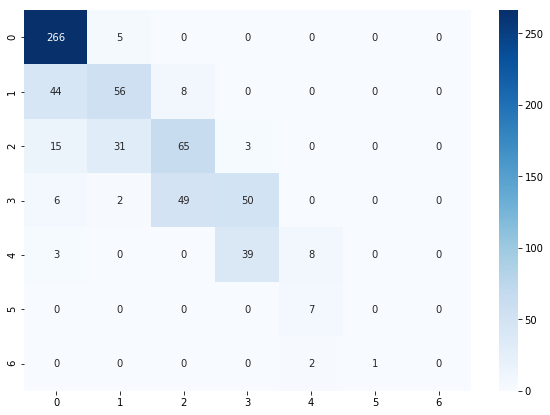

In [125]:
#valuta la classificazione
predictions_max = np.argmax(c_predictions, axis=1)
y_test_max = np.argmax(c_labels, axis=1)

#calcola gli score
accuracy_score_val = accuracy_score(y_test_max, predictions_max)
precision_score_val = precision_score(y_test_max, predictions_max, average='weighted') # tp / (tp + fp)
recall_score_val = recall_score(y_test_max, predictions_max, average='weighted') # tp / (tp + fn)
f1_score_val = f1_score(y_test_max, predictions_max, average='weighted')

#stampa gli score
print("accuracy_score: %0.4f" % accuracy_score_val)
print("precision_score: %0.4f" % precision_score_val)
print("recall_score: %0.4f" % recall_score_val)
print("f1_score: %0.4f" % f1_score_val)

#ottiene e stampa la confusion matrix
cm = confusion_matrix(y_test_max, predictions_max)
df_cm = pd.DataFrame(cm, 
                     index = [i for i in range(cm.shape[0])],
                     columns = [i for i in range(cm.shape[1])])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')